# Problem 1: Importance Sampling

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Fit a model to the data using:
a. Uniform priors on all parameters
b. Modestly informative Gaussian priors on all parameters
c. Strongly informative Gaussian priors on all parameters

Draw samples from the posterior using any sampler of your choosing.

After sampling in cases (b) and (c), calculate importance weights and resample your posteriors in order to "undo" the informative prior. This step will create a vector of unweighted posterior samples from your original vector of weighted posterior samples. Verify that after importance sampling your results are equivalent to what you obtained in case (a).

Examine the posterior distributions. Do you see any numerical noise or other sampling artifacts introduced by importance sampling?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_data(ax, x, y, y_err):
    ax.errorbar(x, y, yerr=y_err, fmt='o', capsize=3, ms=2, c='k')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.tick_params(axis='both', which='major', top=True)
    ax.tick_params(axis='both', which='minor', top=True)
    ax.tick_params(direction='in')
     
def get_model_predictions(theta, x):
    '''
    Calculate the model at any position x
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    Returns
    -------
    model_preds : arr-like, shape (n_samples)
        Array of model values
    '''
    m, b = theta
    model_preds = m*x+b
    
    return model_preds

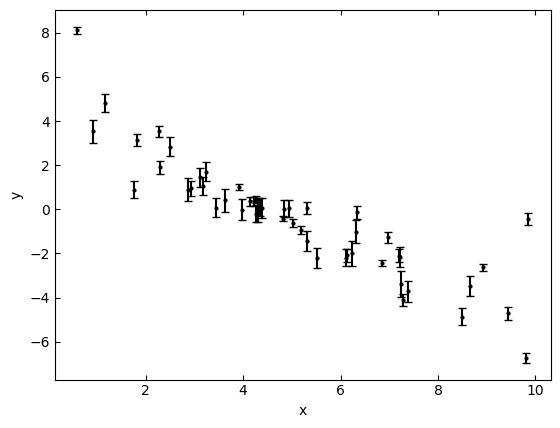

In [9]:
df = pd.read_csv('/Users/nasserm/Documents/vscode/lsstda/Session-23/Day3/line_fitting.csv')

fig, ax = plt.subplots()
plot_data(ax, df['x'], df['y'], df['y_err'])



a) Uniform Priors on all

In [19]:
def lnprior(theta):
    '''
    Calculate the log of the prior for the model parameters
    
    Parameters
    ----------
    theta : tuple
        Model parameters
            
    Returns
    -------
    lnp : float
        The log-prior of the model parameters
    '''
    m, b = theta
    if -10 <= m <= 0 and 0 <= b <= 10:
        lnp = np.log(1/10) + np.log(1/10) # assumes P(m) and P(y) are completely independent
    else:
        lnp = -np.inf
    
    return lnp

In [11]:
def lnlikelihood(theta, y, x, y_unc):
    '''
    Calculate the log likelihood for a model assuming Gaussian uncertainties
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    lnl : float
        The log-likelihood of the observations given the model parameters
    '''
    model_preds = get_model_predictions(theta, x)
    lnl = -np.sum((y-model_preds)**2/(2*y_unc**2))
    
    return lnl

In [26]:
def lnprob(theta, y, x, y_unc):
    return lnprior(theta) + lnlikelihood(theta, y, x, y_unc)

In [13]:
ndim, nwalkers = 2, 100
m0 = np.random.rand(nwalkers, 1)*-10
b0 = np.random.rand(nwalkers, 1)*10
p0 = np.hstack([m0, b0])

In [15]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(df['y'], df['x'], df['y_err']))
sampler.run_mcmc(p0, 1000, progress=True)

You must install the tqdm library to use progress indicators with emcee


State([[-1.08625504  5.33894771]
 [-1.13050045  5.52896282]
 [-1.09599397  5.41862942]
 [-1.11103566  5.45754549]
 [-1.10960287  5.45302013]
 [-1.10120055  5.41336669]
 [-1.11001737  5.41715559]
 [-1.13711157  5.60717166]
 [-1.10592037  5.45198138]
 [-1.1076061   5.46840191]
 [-1.09186119  5.38542871]
 [-1.08388679  5.35829646]
 [-1.11895212  5.52728727]
 [-1.12503539  5.56088204]
 [-1.11864184  5.55688305]
 [-1.11643817  5.49344468]
 [-1.10964697  5.55242657]
 [-1.12556298  5.57135729]
 [-1.08476911  5.36549874]
 [-1.09183529  5.37224975]
 [-1.10428739  5.3781758 ]
 [-1.09344207  5.35637717]
 [-1.13088945  5.61317776]
 [-1.0773736   5.28584145]
 [-1.07522243  5.28130467]
 [-1.09225174  5.4172846 ]
 [-1.10405485  5.45241956]
 [-1.07545699  5.30903898]
 [-1.12879312  5.57794615]
 [-1.12134817  5.58465018]
 [-1.10475793  5.431185  ]
 [-1.10324081  5.44211534]
 [-1.13636201  5.5969376 ]
 [-1.12877099  5.57533149]
 [-1.12545427  5.4695231 ]
 [-1.08282723  5.32617781]
 [-1.13883251  5.63410

In [16]:
def plot_chains(ax, samples, i, labels):
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)


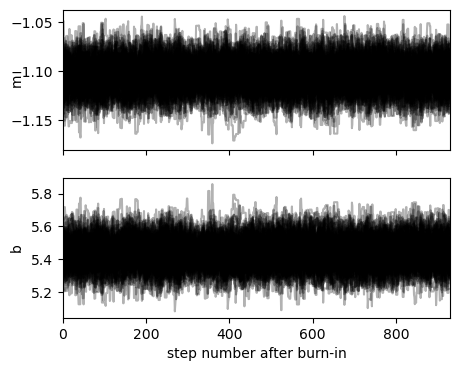

In [17]:
flat_samples = sampler.get_chain(discard=70)
fig, axes = plt.subplots(2, figsize=(5, 4), sharex=True)
labels = ["m", "b"]
for i in range(ndim):
    plot_chains(axes[i], flat_samples, i, labels)

axes[-1].set_xlabel("step number after burn-in");

/opt/anaconda3/envs/day5/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (930) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


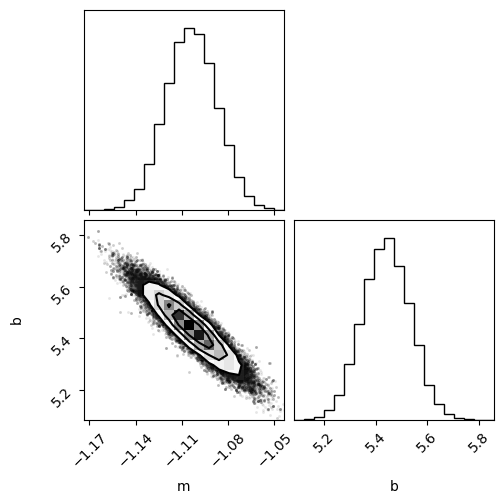

In [18]:
import corner

fig = corner.corner(flat_samples, labels=labels)

b) Moderately informative Gaussian priors

In [23]:
from scipy.stats import norm

In [44]:
norm.logpdf(-2, loc=-1, scale=5)

-2.548376445638773

In [25]:
def lnprior(theta):
    '''
    theta : array
    '''
    lnp_m = norm.logpdf(theta[0], loc=-1, scale=5)
    lnp_b = norm.logpdf(theta[1], loc=8, scale=10)
    return lnp_m +lnp_b
    

In [27]:
ndim, nwalkers = 2, 100
m0 = np.random.rand(nwalkers, 1)*-10
b0 = np.random.rand(nwalkers, 1)*10
p0 = np.hstack([m0, b0])

In [28]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(df['y'], df['x'], df['y_err']))
sampler.run_mcmc(p0, 1000, progress=True)

You must install the tqdm library to use progress indicators with emcee


State([[-1.10309974  5.45545929]
 [-1.09146096  5.36615279]
 [-1.08435653  5.31029969]
 [-1.1041669   5.48342703]
 [-1.1102961   5.43579652]
 [-1.10705986  5.47038088]
 [-1.07306205  5.35393864]
 [-1.0860522   5.37940326]
 [-1.11681087  5.45067105]
 [-1.08347326  5.33440434]
 [-1.10439398  5.41595057]
 [-1.10995405  5.47679874]
 [-1.103312    5.45444247]
 [-1.10240738  5.46861207]
 [-1.09429336  5.39093667]
 [-1.09744313  5.45001083]
 [-1.09095177  5.44951841]
 [-1.10381865  5.44452325]
 [-1.12130497  5.51211945]
 [-1.09527004  5.3352382 ]
 [-1.09684544  5.31946798]
 [-1.10378449  5.45499028]
 [-1.09372679  5.35737282]
 [-1.10866929  5.4702164 ]
 [-1.10755821  5.45216086]
 [-1.1250576   5.52834143]
 [-1.10720626  5.43109196]
 [-1.10280173  5.4110191 ]
 [-1.09679729  5.39479333]
 [-1.08316131  5.3254058 ]
 [-1.10106802  5.39616936]
 [-1.08307778  5.36114462]
 [-1.10449279  5.43524502]
 [-1.08054316  5.38198092]
 [-1.12598679  5.57352034]
 [-1.11759625  5.57462333]
 [-1.11863221  5.52608

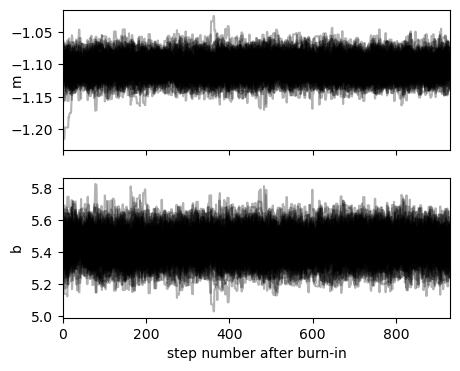

In [29]:
flat_samples = sampler.get_chain(discard=70)
fig, axes = plt.subplots(2, figsize=(5, 4), sharex=True)
labels = ["m", "b"]
for i in range(ndim):
    plot_chains(axes[i], flat_samples, i, labels)

axes[-1].set_xlabel("step number after burn-in");

/opt/anaconda3/envs/day5/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (930) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


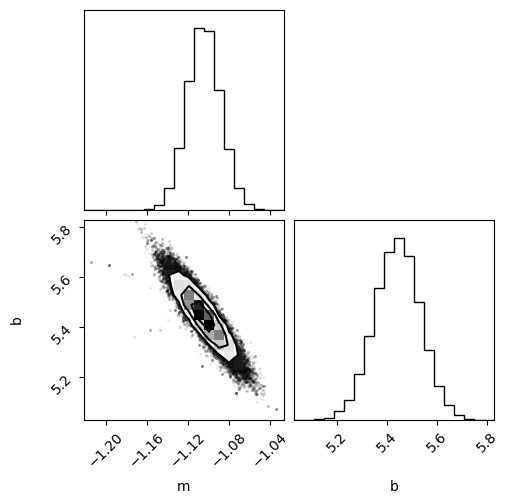

In [30]:
import corner

fig = corner.corner(flat_samples, labels=labels)

c) Strongly informed gaussian priors

In [90]:
def lnprior(theta):
    '''
    theta : array
    '''
    m, b = theta
    lnp_m = norm.logpdf(theta[0], loc=-1.2, scale=0.1)
    lnp_b = norm.logpdf(theta[1], loc=5.5, scale=0.1)
    lnp = lnp_b+lnp_m
    
    return lnp
    

In [91]:
ndim, nwalkers = 2, 100
m0 = np.random.rand(nwalkers, 1)*-10
b0 = np.random.rand(nwalkers, 1)*10
p0 = np.hstack([m0, b0])

In [92]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(df['y'], df['x'], df['y_err']))
sampler.run_mcmc(p0, 1000, progress=True)

State([[-1.09503481  5.35983198]
 [-1.10693156  5.44897222]
 [-1.1001707   5.40075356]
 [-1.12518122  5.53479016]
 [-1.10563484  5.51787671]
 [-1.10349346  5.50034077]
 [-1.08454651  5.35171976]
 [-1.12735155  5.50482284]
 [-1.0958619   5.44839985]
 [-1.09075895  5.34965645]
 [-1.11033916  5.48041966]
 [-1.12274763  5.61758933]
 [-1.10217329  5.44444786]
 [-1.11128167  5.4740892 ]
 [-1.10761631  5.48253944]
 [-1.1239692   5.60049175]
 [-1.11217535  5.5084534 ]
 [-1.11732782  5.54838309]
 [-1.12907811  5.61190543]
 [-1.08754956  5.41136326]
 [-1.12259232  5.53146061]
 [-1.115053    5.49976175]
 [-1.1267138   5.56304111]
 [-1.11568633  5.4993882 ]
 [-1.11719491  5.50497643]
 [-1.11016647  5.46674059]
 [-1.09055437  5.40380447]
 [-1.12210155  5.55702783]
 [-1.09975785  5.46859057]
 [-1.13444115  5.60035874]
 [-1.1137495   5.46068605]
 [-1.11075116  5.45603794]
 [-1.11123474  5.46718566]
 [-1.10169261  5.49870655]
 [-1.1069001   5.48141734]
 [-1.10799229  5.41433212]
 [-1.09706327  5.40203

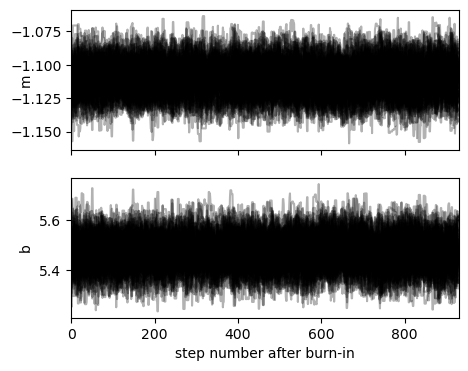

In [93]:
flat_samples = sampler.get_chain(discard=70)
fig, axes = plt.subplots(2, figsize=(5, 4), sharex=True)
labels = ["m", "b"]
for i in range(ndim):
    plot_chains(axes[i], flat_samples, i, labels)

axes[-1].set_xlabel("step number after burn-in");

/opt/anaconda3/envs/day5/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (930) than draws (100). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


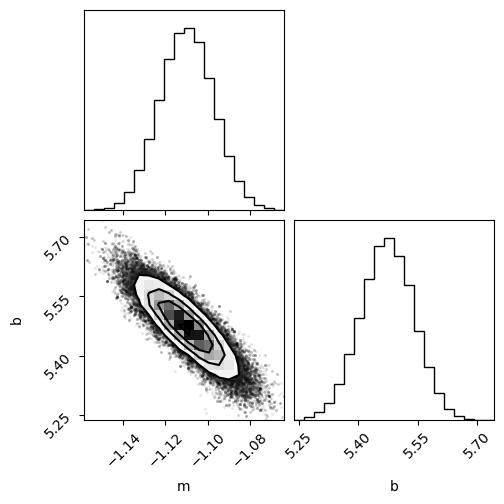

In [94]:
import corner

fig = corner.corner(flat_samples, labels=labels)

d) Resample the posteriors

In [95]:
np.shape(flat_samples[:,:,0])

(930, 100)

In [120]:
flat_samples[:,:,0].flatten()

array([-1.10350474, -1.10870626, -1.13141424, ..., -1.10558641,
       -1.09990147, -1.10973575])

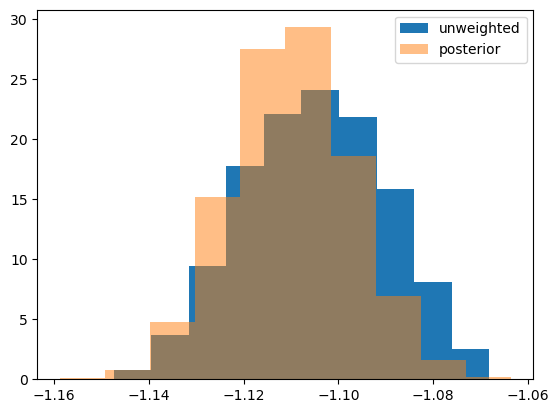

In [140]:
flat_m = flat_samples[:,:,0].flatten()
flat_b = flat_samples[:,:,1].flatten()


weights = 1/np.exp(lnprior([flat_m, flat_b]))

normalized_weights = weights / np.sum(weights)

# Now use normalized weights for resampling with replecement
resample = np.random.choice(flat_m, 1000, p=normalized_weights)
plt.hist(resample, density=True, label='unweighted')
plt.hist(flat_m, alpha=0.5, density=True, label='posterior')
plt.legend()

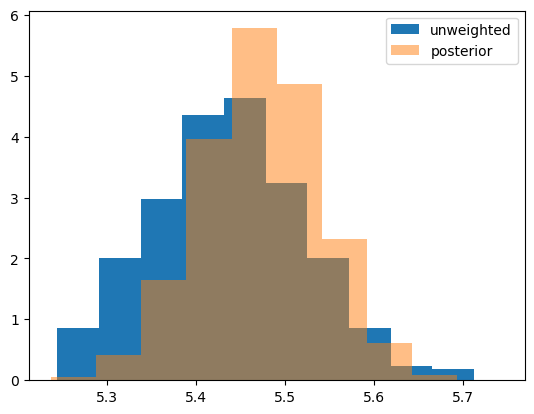

In [141]:
flat_m = flat_samples[:,:,0].flatten()
flat_b = flat_samples[:,:,1].flatten()


weights = 1/np.exp(lnprior([flat_m, flat_b]))

normalized_weights = weights / np.sum(weights)

# Now use normalized weights for resampling with replecement
resample = np.random.choice(flat_b, 1000, p=normalized_weights)
plt.hist(resample, density=True, label='unweighted')
plt.hist(flat_b, alpha=0.5, density=True, label='posterior')
plt.legend()

# Problem 2: Umbrella Sampling Tutorial

Work through the umbrella sampling tutorial here: https://gjgilbert.github.io/tutorials/umbrella_sampling/

Once you complete the tutorial, return to the Line Fitting dataset from Problem 1. Fit a model using umbrella sampling. You'll need to choose how to define your umbrella windows and biases - there are many possible solutions! After sampling from individual umbrellas, combine your samples into a single set of posterior samples. Verify that the results you obtain from umbrella sampling are equivalent to the results you obtain from other methods.

# Problem 3: Reparameterizing a Model

Read in the Two Component Sinusoid dataset (two_component_sinusoid.csv) and plot the data.

Fit a model using the most "obvious" parameterization:

$y(x) = A_1 \sin(2\pi f_1 x - \phi_1 + A_2 \sin(2\pi f_2 x - \phi_2)$

Place appropriate independent priors on each of the six free parameters. Try fitting a model, drawing samples using a sampler of your choosing. Check for convergence and assess the quality of your results. Re-run your model a few times and check if your results remain consistent from run-to-run.

You will probably not acheive a very good fit using this parameterization. Why is this parameterization problematic? Re-parameterize the model in order to get a more robust fit. Check for convergence and that your posteriors remain consistent from run-to-run.